## Import Modules

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import os

## Import Data

In [ ]:
from src.routines import *
subject = mats2dict(fVerbose=True)

In [ ]:
fs = 2000

fig, axs = plt.subplots(6,1,figsize=(25,30))
i = 0
a,b = 7,9
a,b = [int(x*fs*60) for x in (a,b)]
for sub_id in [1,2,4,6,7,8]:
    data = subject[sub_id]['Recording'][:4,a:b]
    data_filt = Butterworth(data, ['Bandpass', [40,250],6,fs])
    time = np.arange(0,data.shape[1])/fs

    for signal in data:
        axs[i].plot(time,signal-signal.mean())
        
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (mV)')
    i += 1

# Back to the drawing board

The ultimate goal is to collapse all space into one dimension that varies over time. This way, we can use peak analysis algorithms to best determine peaks in the time course that are associated to the peaks in the swallow. Ultimately, the goal will be to optimize the function that collapses all of space into one dimension by using the ground truth of a subject swallowing.

The easiest way I can think of collapsing it would be to take the norm.

$$z(t) = ||x(t)-E[x(t)]||_{\Sigma^{-1}}$$
$$\Sigma = I$$


In [ ]:
# Select a subject
sub_id = 1
fs=4000

# Import clicker information
clicker_time = np.array(subject[sub_id]['Timestamps'])
print(clicker_time.shape)

# Set up window where subject was pressing the button
a,b = clicker_time[0],clicker_time[-1]
a,b = int(a-10)*fs,int(b+10)*fs
print(a,b)

# Get data
data = subject[sub_id]['Recording'][:4]
time = np.arange(0,data.shape[1])/fs

# Plot data
plt.figure(figsize=(25,5))
plt.vlines([x for x in clicker_time], ymin=-4000, ymax=4000, colors='r', linestyle='--')
for signal in data:
    plt.plot(time,signal-signal.mean())
#plt.xlim((0,800))

In [ ]:
T = 250
noise_data = subject[sub_id]['Recording'][:,0:140*fs]
#noise_data = Butterworth(noise_data,['bandpass',[10,250],4,fs])
cov_noise = Covariance(noise_data, Robust=[T,3,'Geodesic'])

plt.imshow(cov_noise)

In [ ]:
fs = 4000
T = 250
X = subject[sub_id]['Recording'][:,140*fs:]
#X = Butterworth(X,['bandpass',[10,250],4,fs])

M = int(T/1000*fs)
N = int(X.shape[1]/M)
Leak = int(1/8*M)
Cov = EmpiricalCovariance()
Precision_Samples = np.array([Cov.fit(X[:,M*i:M*(i+1)].T).precision_ for i in range(N)])
Distance = np.array([Geodesic(Precision,cov_noise) for Precision in Precision_Samples])

import scipy
from scipy.ndimage import gaussian_filter
Distance_filt = gaussian_filter(Distance, sigma=2)
peaks, properties = scipy.signal.find_peaks(Distance_filt, width = fs/M, height=6, distance=10)
print('Num of peaks: ', len(peaks))
print('Peak information: ', *properties.keys(), sep='\t')
print(Distance.shape)

fig,ax = plt.subplots(1,1,figsize=(30,10))
ax.plot(np.arange(0,N*M,M),Distance)
ax.plot(np.arange(0,N*M,M),Distance_filt,linewidth=4)
ax.plot(peaks*M,Distance_filt[peaks], 'bo')

plt.vlines([x*fs-140*fs for x in clicker_time], ymin=15, ymax=20, colors='r', linestyle='--')

#plt.xlim((200000,500000))

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

cutoffs = clicker_time.reshape(-1,2)*fs-140*fs
avg_closest = [int(find_nearest(peaks*M, (a+b)/2)/M) for a,b in cutoffs]
index_closest = np.squeeze([np.where(peaks == x)[0] for x in avg_closest])
peaks_new, properties_new = peaks[index_closest], {key: properties[key][index_closest] for key in properties.keys()}



In [ ]:
print('Num of peaks: ', len(peaks_new))
print('Properties has: ', *properties_new.keys(),sep='\t ')

keys = properties_new.keys()
plt_rows = int(np.ceil(len(keys)/3))
fig,axs = plt.subplots(plt_rows,3, figsize = (5*plt_rows,15))
axs = axs.ravel(); i = 0
for key in properties_new.keys():
    axs[i].boxplot(properties_new[key].reshape(5,6).T)
    axs[i].set_title(key)
    axs[i].set_xticklabels(['Dry','Water','Apple sauce', 'Fruit cup', 'Cracker'])
    i += 1

## Import some modules and data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import os
import scipy
from scipy.ndimage import gaussian_filter1d

from src.routines import Butterworth, mats2dict

# Import data
sub_id = 3
subject = mats2dict(sub_load=[sub_id])


Subjects imported:  3
Subject information: 	Information	Recording	Sampling Frequency	Timestamps


## Compute z(t), envelope, and peaks


In [2]:
fs = subject['Sampling Frequency']

# x(t) is a time-varying vector of size nChannels
x = np.array(subject['Recording']);      
x = Butterworth(x, ['bandpass', [70,250], 4, fs])
z = np.linalg.norm(x.T-np.mean(x,axis=1), axis = 1)**2

# Create time vector
t = np.arange(0,x.shape[1])/fs

# Important cutoff values from swallows and tasks
clicker_information = np.array(subject['Timestamps'])
cutoffs_swallows = clicker_information.reshape(-1,2)
cutoffs_tasks = [(cutoffs_swallows[i][0]-3,cutoffs_swallows[i+5][1]+3) for i in np.arange(5)*6]

# Compute envelope with a gaussian filter.
sigma = 25
z_env = gaussian_filter1d(z, sigma=sigma)

# # Find peaks based on height
# height_peaks = [max(z_env[int(a*fs):int(b*fs)]) for a,b in cutoffs_swallows] # based on power during a swallow
# height_extrema = min(height_peaks), max(height_peaks) 
# Re-define peak threshold by taking statistics from the noise experiment
'''
    I am making the assumption that the noise period in the experiments occurs in the 
    first two minutes of the experiment.
'''
z_noise = z[:120*fs]
height_extrema = z_noise.mean() + 2*z_noise.std()
peaks, _ = scipy.signal.find_peaks(z_env, height=height_extrema)

# Show some outputs
print('Experiment information: ',
    f'nChannels = {x.shape[0]}',
    f'time_samples = {x.shape[1]}',
    sep = '\n\t')
print('Parameters for find_peaks(): ',
    f'\n\tMin thresholds = \t\t{height_extrema}')#[int(x) for x in height_extrema]}')
print('Peaks found inside cutoffs:',
    f'Number of peaks found = \t{len(peaks)}',
    #f'Cutoffs containing peaks = \t{sum([peak.any() for peak in peaks_filt])}',
    sep='\n\t')



Experiment information: 
	nChannels = 20
	time_samples = 1438683
Parameters for find_peaks():  
	Min thresholds = 		4480.567667505278
Peaks found inside cutoffs:
	Number of peaks found = 	2323


## Plot all experiment
Here we plot z(t), its envelope (computed with a gaussian filter), the peaks, and the times a button was clicked.

Text(0.5, 0, 'Time (sec)')

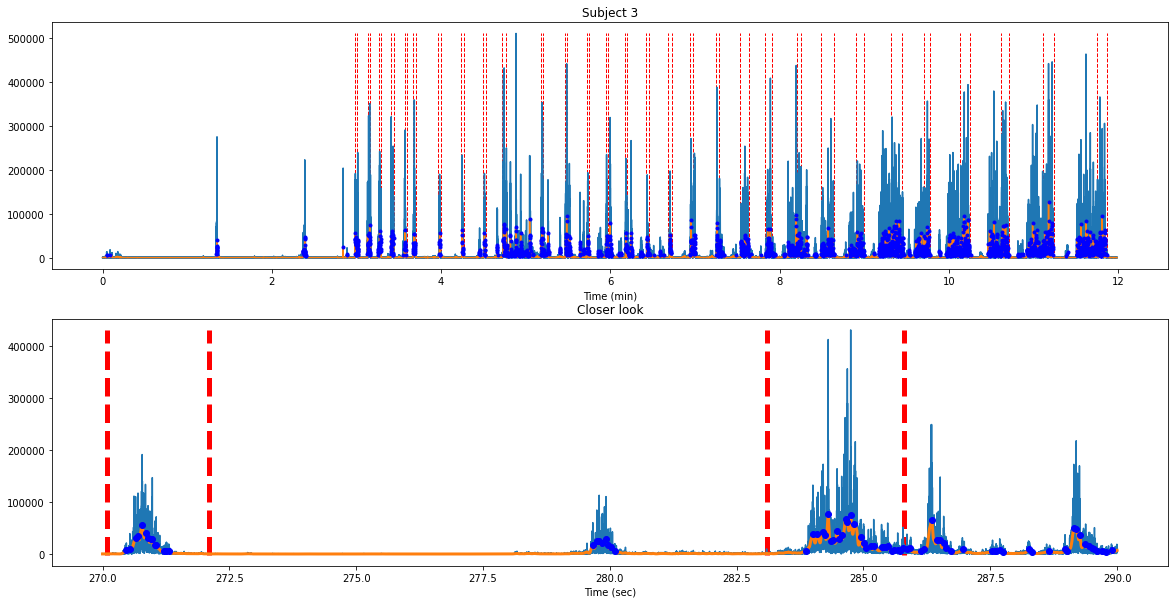

In [46]:
fig, axs = plt.subplots(2,1, figsize=(20,10))

axs[0].plot(t/60,z)
axs[0].plot(t/60,z_env)
axs[0].plot(peaks/fs/60, z_env[peaks],'b.')
axs[0].vlines([i/60 for i in clicker_information], ymin=-1000, ymax=max(z), colors='r', linestyle='--', linewidth=1)
axs[0].set_title('Subject %i'%sub_id)
axs[0].set_xlabel('Time (min)')

a,b = 270,290
a,b = [x*fs for x in [a,b]]
axs[1].plot(t[a:b],z[a:b])
axs[1].plot(t[a:b],z_env[a:b],linewidth=3)
peaks_new = peaks[[a<peak<b for peak in peaks]]
axs[1].plot(peaks_new/fs, z_env[peaks_new],'bo')
axs[1].vlines([i for i in clicker_information if a<i*fs<b], ymin=-1000, ymax=max(z[a:b]), colors='r', linestyle='--',linewidth=5)
axs[1].set_title('Closer look')
axs[1].set_xlabel('Time (sec)')

In [8]:
fig.savefig('figures/report_102721_norm2/subject_%s'%sub_id)

## Plot swallows for all tasks

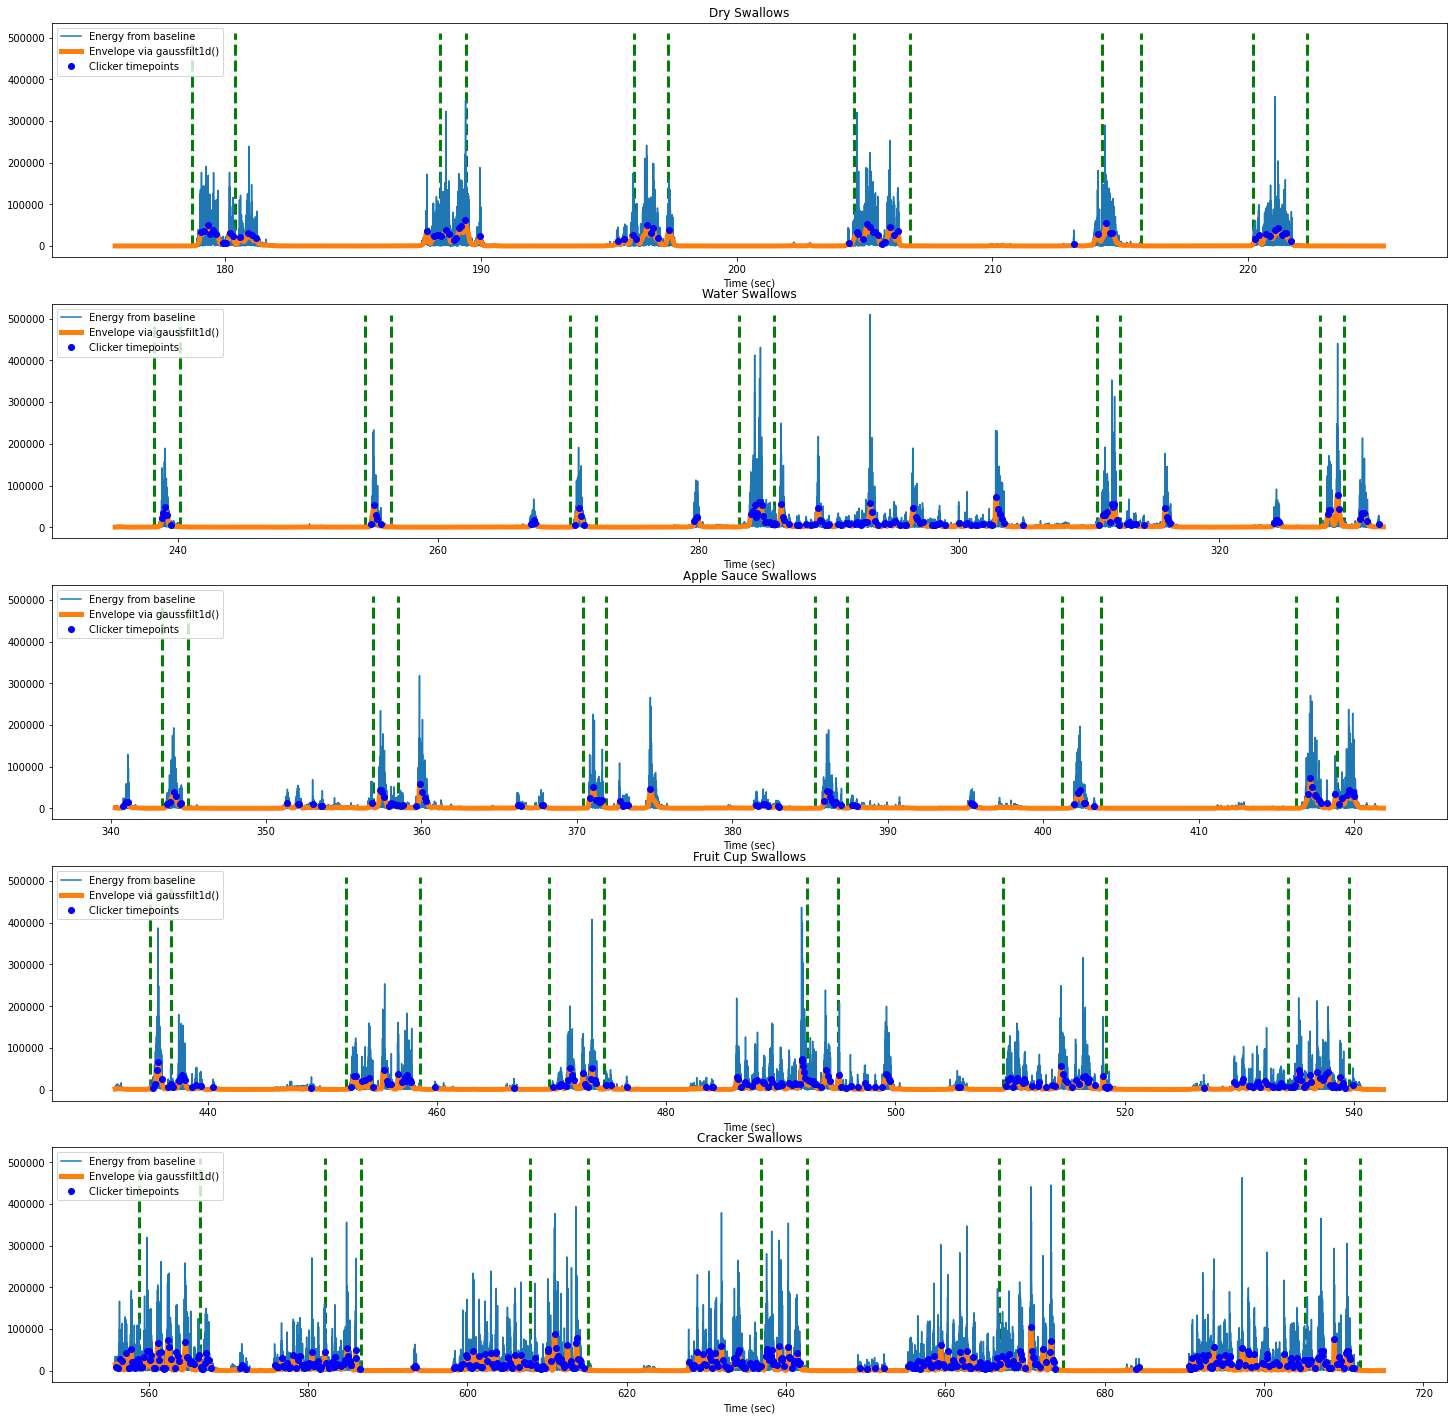

In [22]:
fig,axs = plt.subplots(5,1,figsize=(25,25))

peaks_filt_all = np.hstack((peaks))
tasks = ['Dry', 'Water', 'Apple Sauce', 'Fruit Cup', 'Cracker']
for cutoff,task,ax in zip(cutoffs_tasks,tasks,axs):
    # Get task domain
    a,b = cutoff 
    a,b = [int(x*fs) for x in cutoff]
    # Plot values
    ax.plot(t[a:b], z[a:b])
    # Plot envelope
    ax.plot(t[a:b], z_env[a:b], linewidth=5)
    # Use a mask to filter peaks pertaining to this task
    mask = np.logical_and(peaks_filt_all>a,peaks_filt_all<b)
    peaks_filt_task = peaks_filt_all[mask]
    # Plot peaks
    ax.plot(peaks_filt_task/fs, z_env[peaks_filt_task],'bo')
    # Plot button presses
    ax.vlines([i for i in clicker_information if a<i*fs<b], ymin=-1000, ymax=max(z), colors='g', linestyle='--',linewidth=3)
    # Plot properties
    #ax.set_ylim((0, height_extrema))
    ax.set_title(task + ' Swallows')
    ax.legend(['Energy from baseline', 'Envelope via gaussfilt1d()', 'Clicker timepoints'], loc='upper left')
    ax.set_xlabel('Time (sec)')


## Get peak features

In [4]:
# Get parameters for feature extraction
T_swallow = [cutoff[1]-cutoff[0] for cutoff in cutoffs_swallows]
wlen = np.mean(T_swallow)*fs
# width = np.quantile(T_swallow, 0.25)*fs/10      # based on clicking pattern
# height_peaks = [max(z_env[int(a*fs):int(b*fs)]) for a,b in cutoffs_swallows] # based on power during a swallow
# height_extrema = min(height_peaks)/2, max(height_peaks) 
# prominence = height_extrema[0]/2

# Add a mask on (peaks, properties) output of sp.signal.find_peaks() to filter peaks that happened during the swallow.
peaks_filt_swallow = []
for cutoff in cutoffs_swallows:
    a,b = [int(x*fs) for x in cutoff]
    mask = np.logical_and(peaks>a,peaks<b)
    peaks_filt_swallow.append(peaks[mask])
peaks_filt = np.hstack((peaks_filt_swallow))

# Compute prominences
prominence, left_bases, right_bases = scipy.signal.peak_prominences(z_env, peaks_filt, wlen)

# Compute width of peaks
widths, width_heights, left_ips, right_ips = scipy.signal.peak_widths(z_env, peaks_filt, rel_height= 0.75, prominence_data = (prominence, left_bases, right_bases))


## Plot single swallow with features

Number of peaks found: 8
position in time: [188.4345 188.631  188.734  188.9245 189.0355 189.138  189.212  189.3875] sec
length of left base: [0.0256922  0.52547155 0.01497664 0.02473368 0.006367   0.01014429
 0.10212107 0.38361332] sec
length of right base: [0.02630873 0.15004639 0.00984068 0.02815776 0.00978247 0.01541179
 0.04823247 0.15569348] sec


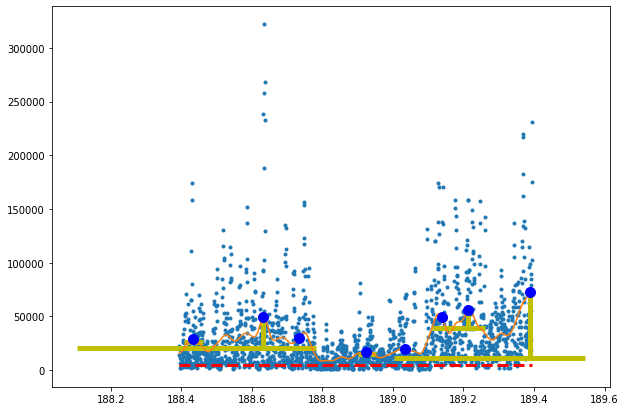

In [47]:
swallow = 1

plt.figure(figsize = (10,7))

# Get domain of plot
cutoff = cutoffs_swallows[swallow] 
a,b = [int(x*fs) for x in cutoff]
# Plot raw output
plt.plot(t[a:b],z[a:b],'.',zorder=0)
# Plot gaussian filtered data
plt.plot(t[a:b],z_env[a:b])
# Plot parameters 
plt.hlines(y = height_extrema, xmin=a/fs, xmax=b/fs,
    colors='r', linestyle='--', linewidth=3)
# Plot peaks from find_peaks() only if they are within the swallow.
mask = np.logical_and(peaks_filt>a,peaks_filt<b)
peak_swallow = peaks_filt[mask]
plt.plot(peak_swallow/fs, z_env[peak_swallow],'bo',markersize=10)
# Plot peak features
peak_height = z_env[peak_swallow]
peak_contour = peak_height - prominence[mask]
#print(peak_swallow, width_heights[mask], peak_height,peak_contour)
plt.vlines(x=peak_swallow/fs,ymin=peak_contour, ymax=peak_height,linewidth=5,colors='y')
plt.hlines(y=peak_contour, xmin=left_ips[mask]/fs, xmax=right_ips[mask]/fs,
    linewidth=5,colors='y')

# Print peak features
print('Number of peaks found: %d'%len(peak_swallow),
    f'position in time: {peak_swallow/fs} sec',
    f'length of left base: {(peak_swallow-left_ips[mask])/fs} sec',
    f'length of right base: {(right_ips[mask]-peak_swallow)/fs} sec',
    sep='\n')
#print(f'peak_pos \t= {peak_swallow/fs} sec')


## Plot features

In [48]:
# y_heights = np.array([max(x) for x in properties_filt['peak_heights']])
# y_prominences = np.array([max(x) for x in properties_filt['prominences']])
# y_left_ips = np.array([max(x) for x in properties_filt['prominences']])
# 

# print(y_heights)
x_tasks = np.linspace(1,6, num=30,dtype=int,endpoint=False)
y_num_peaks = np.array([len(peaks_swallow) for peaks_swallow in peaks_filt_swallow])
y_prominences = y_mini_prominences = y_width = np.zeros_like(y_num_peaks)
for i,cutoff in enumerate(cutoffs_swallows):
    a,b = [int(x*fs) for x in cutoff]
    mask = np.logical_and(peaks_filt>a,peaks_filt<b)
    prominence_swallow = prominence[mask]
    y_prominences[i] = prominence_swallow.max()   # Only use the tallest
    y_mini_prominences[i] = np.delete(prominence_swallow, np.argmax(prominence_swallow)).mean()
    y_width[i] = widths[mask].max()


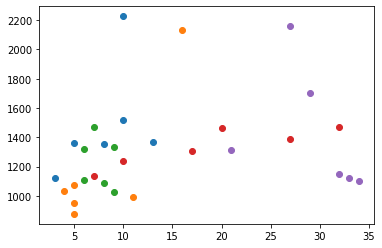

In [50]:
# for feature in [y_num_peaks]:
#     plt.scatter(x_tasks, feature)
tasks = ['dry','water','sauce','fruit cup','cracker']
for i,task in enumerate(tasks, start=1):
    mask = x_tasks == i
    plt.scatter(y_num_peaks[mask],y_mini_prominences[mask])

# Summary

In [17]:
import numpy as np 
import matplotlib.pyplot as plt 
from src.routines import mats2dict, Butterworth
import scipy as sp 
from scipy import signal, ndimage

def return_features(subject, sigma=400):
    # Get subject information
    fs = subject['Sampling Frequency']
    x = np.array(subject['Recording']); # (n,T)
    clicker_information = np.array(subject['Timestamps'])  

    # Pre-processing methods
    x = Butterworth(x, ['bandpass', [70,250], 4, fs])   # (n,T)
    cutoffs_swallows = clicker_information.reshape(-1,2)
    cutoffs_tasks = [(cutoffs_swallows[i][0]-3,cutoffs_swallows[i+5][1]+3) for i in np.arange(5)*6]

    # Compute activity time course with weighted norm
    z = np.linalg.norm(x.T-np.mean(x,axis=1), axis = 1)**2 # (1,T)
    print(x.T.shape, np.mean(x,axis=1).shape)

    # Compute envelope with a gaussian filter.
    z_env = ndimage.gaussian_filter1d(z, sigma=sigma)

    # Find peaks conditioned on the first 2 minutes of rest.
    z_noise = z[:120*fs]
    height_extrema = z_noise.mean() + 2*z_noise.std()
    peaks, _ = signal.find_peaks(z_env, height=height_extrema)

    # Extract width of peaks.
    T_swallow = [cutoff[1]-cutoff[0] for cutoff in cutoffs_swallows]
    wlen = np.mean(T_swallow)*fs
    widths, width_heights, left_ips, right_ips = signal.peak_widths(z_env, peaks, rel_height= 0.5, wlen=wlen)

    # Return features indexed by swallow. 
    y_tasks = np.linspace(1,6, num=30,dtype=int,endpoint=False)
    x_features = np.zeros((6,y_tasks.shape[-1]))
    for i,cutoff in enumerate(cutoffs_swallows):
        a,b = [int(x*fs) for x in cutoff]
        mask = np.logical_and(peaks>a,peaks<b)
        n = widths[mask].argmax()
        x_features[0,i] = len(peaks[mask])
        x_features[1,i] = widths[mask].max()    # Only return the biggest
        x_features[2,i], x_features[3,i] = np.vstack((left_ips,right_ips))[:,n]-peaks[n]
        x_features[4,i] = width_heights[mask].max()
        x_features[5,i] = (widths[mask]*width_heights[mask]).sum()

    return y_tasks, x_features


In [7]:
subject = mats2dict(sub_load=[3])

Subjects imported:  3
Subject information: 	Information	Recording	Sampling Frequency	Timestamps


In [18]:
y_tasks, x_features = return_features(subject)

(1438683, 20) (20,)


NameError: name 'scipy' is not defined

# Extra stuff

In [57]:
from sklearn.decomposition import PCA

y_tasks, x_features = return_features(subject)

pca = PCA(n_components=2)
PCs = pca.fit_transform(x_features.T)



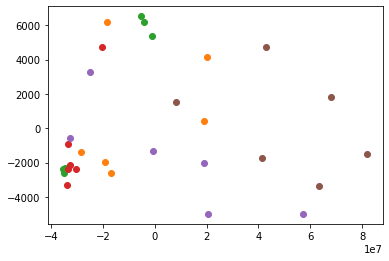

In [71]:
cmap = [0.1, 0.2, 0.3, 0.4, 0.5]
for i in range(1,6):
    mask = y_tasks == i 
    plt.scatter(PCs[mask][:3,0],PCs[mask][:3,1],c='C%s'%i)#,marker='.')
    plt.scatter(PCs[mask][3:,0],PCs[mask][3:,1],c='C%s'%i)

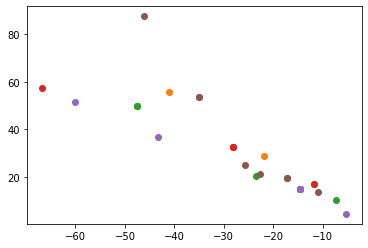

In [49]:
for i in range(6):
    mask = y_tasks == i 
    plt.scatter(x_leftwidth[mask],x_rightwidth[mask])

In [ ]:
# Signal input for peak detection
Z = z

# Compute parameters for peak-finding function. 
cutoffs = np.array(subject[sub_id]['Timestamps']).reshape(-1,2)
T_swallow = [cutoff[1]-cutoff[0] for cutoff in cutoffs]
T_rest = [cutoffs[i+1][0]-cutoffs[i][1] for i in range(len(cutoffs)-1)]
width = np.mean(T_swallow)                  # Assign the expected value of the peak width

cutoff_tasks_samples = [int(cutoffs[i*6+5][1]*fs + 3*fs) for i in np.arange(5)]
# max_distances_task = [1, 1, 2, 3, 4]
# max_distances = np.zeros_like(Z)
# for i in range(5):
#     a,b = cutoff_tasks_samples[i],cutoff_tasks_samples[i+1]
#     max_distances[a:b] = width*max_distances_task

T_rest_bt_swallows = np.delete(T_rest, np.arange(4)*6+5)
gap_thresh_task = [min(T_rest_bt_swallows[i*6:(i+1)*6])/2*fs for i in range(5)]
gap_thresh = np.zeros_like(Z)
N_0 = int(cutoffs[0][0]*fs-5*fs)
for i in range(5):
    N = cutoff_tasks_samples[i]
    print(gap_thresh.shape,N_0,N)
    gap_thresh[N_0:N] = gap_thresh_task[i]
    N_0 = N



# if z 
# max_distances = width*   # Expected distance of peaks for one task

# min_len = width*3

# gap_thres = 

# Find peaks via wavelet
peaks = scipy.signal.find_peaks_cwt(z, widths=)#, gap_thresh=gap_thresh)

# plt.hist(T_swallow)
# plt.hist(T_rest)

#print(np.delete(T_rest, np.arange(4)*6+6))

In [ ]:
plt.plot(z)  

In [ ]:
good_subjects = [1,2,4,6,7,8]
x = [Butterworth(subject[sub_id]['Recording'][:,:-fs], ['bandpass', [20,250], 4, fs]) for sub_id in good_subjects]
z = [np.linalg.norm(x_sub, axis = 0)**2 for x_sub in x]

fig, axs = plt.subplots(len(z),1, figsize = (30,15))

for ax,z in zip(axs,z):
    ax.plot(z)